**Do not change this version from 0.45**



In [ ]:
pip install qiskit==0.45 qiskit_aer

In [ ]:
import numpy as np
import math
import time
import scipy
from matplotlib import pyplot as plt

# Importing standard Qiskit libraries
from qiskit import *
from qiskit.quantum_info import DensityMatrix, partial_trace
from qiskit.visualization import plot_state_city

from qiskit import quantum_info
from qiskit.extensions import UnitaryGate
from qiskit.quantum_info.operators import Operator
import qiskit.quantum_info as qi
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.primitives import Sampler as Sampler
from qiskit import Aer
from qiskit import execute,  BasicAer
from qiskit.circuit.random import random_circuit
from qiskit import QuantumRegister
import numpy as np
from qiskit import ClassicalRegister
from qiskit.circuit.library import RYGate

#Paulis
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])
I = np.identity(2)

#|0> and |1>
one = np.array([0,1])
zero = np.array([1,0])

def tensor(a,b,c):
  """
  Returns the tensor product of numpy arrays a,b, and c.
  """
  return np.kron(np.kron(a,b),c)

def tensorbig(lst):
    """
    Returns the tensor product of the arrays in lst.

    Preconditions:
    - lst contains only Numpy arrays
    """
    result = lst[0]
    for i in range(1, len(lst)):
        result = np.kron(result, lst[i])
    return result


def unitary(U):
  """Returns whether a numpy matrix is unitary"""
  return np.allclose(np.eye(U.shape[0]), np.dot(U, U.conjugate().T))


def flip(counts):
  """
  Given a dictionary counts with a string key, it returns
  a new dictionary with the key reversed and the value the same.

  Used for switching the endianness of the measurements.
  """
  res = {}
  for k,v in counts.items():
    res[k[::-1]] = v
  return res

In [ ]:
#J Parameters
kappa = 64.5
kappa = np.sqrt(kappa)
gamma = np.sqrt(.4)

zero2 = np.array([1,0,0,0])
one2 =  np.array([0,1,0,0])
two = np.array([0,0,1,0])
three = np.array([0,0,0,1])

#Destroy operator
a = (np.outer(zero2, one2) + np.sqrt(2) * np.outer(one2, two) + np.sqrt(3) * np.outer(two, three))

sigma = np.outer(zero, one)
isigma = tensor(I, I, sigma)

def next_power(n):
    """Finds the first number >= n that is also a
    power of 2.

    Used for figuring out the size and padding of the JMatrix."""
    power = 1
    while power < n:
        power <<= 1
    return power

def makeJ(emitters):
  """
  Makes the J Matrix for an arbitary number of emitters. Returns the matrix,
  the number of qubits, and the number of ancillas.

  First, make the Lindblad operators for the cavity and the emitters. Then,
  calculate the padding needed and make the JMatrix using np.block.

  Precondition: emitters is an int
  """
  a = (np.outer(zero2, one2) + np.sqrt(2) * np.outer(one2, two) + np.sqrt(3) * np.outer(two, three))

  L1 = tensorbig([kappa * a] + [I for i in range(emitters)])

  L_emitters = [np.array(tensorbig([I,I]+[I for j in range(i)]+ [gamma * np.outer(zero, one)]+[I for j in range(i+1, emitters)])) for i in range(emitters)]
  elems = 2 * L1.shape[0] + sum(i.shape[0] for i in L_emitters)
  padding = next_power(elems) - elems

  chunk_size = L1.shape[0]

  Jtop = np.block([[np.zeros((chunk_size, chunk_size)), np.zeros((chunk_size, padding)), L1.conjugate().T] + [i.conjugate().T for i in L_emitters]])
  J = np.block([[Jtop], [np.zeros((padding, elems + padding))]])
  J = np.block([[J], [L1, np.zeros((chunk_size, elems+padding-chunk_size))]])
  for i in range(emitters):
    J = np.block([[J], [L_emitters[i], np.zeros((chunk_size, elems+padding-chunk_size))]])


  qubits = np.log2(J.shape[0])
  ancilla = qubits - 2 - emitters
  return J, qubits, ancilla

In [ ]:
#Hamiltonian Parameters
wc = 0
we = [200, 500, 750, 400]
g = 100

def makeH(emitters, t, N, drive = False):
  """
  Makes and returns the Hamiltonian matrix.

  Parameter emitters: the number of emitters
  Precondition: emitters is a positive int.

  Parameter t: the simulation time
  Precondition: t is a positive float

  Parameter N: the number of times to apply J and H
  Precondition: N is a positive int

  Parameter drive: Whether or not to have a drive
  Precondition: drive is a boolean.
  """
  #the term outside the sum
  wd = wc-g
  adagaN = tensorbig([np.dot(a.conjugate().T, a)] + [I for _ in range(emitters)])
  Hn = g*adagaN

  for i in range(emitters):
    #First term in the sum
    Hn += (we[i]-wd) * tensorbig((2 + i) * [I] + [np.outer(one, one)] + (emitters-i-1) * [I])

    #The cavity-emitter coupling term
    sigan = np.dot(tensorbig((2+i) * [I] + [sigma.conjugate().T] + (emitters-i-1) * [I]), tensorbig([a] + [I for _ in range(emitters)]))
    sigan += np.dot(tensorbig([a.conjugate().T] + [I for _ in range(emitters)]), tensorbig((2+i) * [I] + [sigma] + (emitters-i-1) * [I] ))
    Hn += g*sigan
  if drive:
    end = tensorbig([a] + [I for _ in range(emitters)]) * np.exp(1j * wc * t/N) + tensorbig([a.conjugate().T] + [I for _ in range(emitters)]) * np.exp(-1j * wc * t/N)
    end = tensorbig([a + a.conjugate().T] + [I for _ in range(emitters)])
    Hn = Hn + (kappa**2) * .5 *  end
  return Hn

Let's turn our two matrices into quantum gates.

The unitaries are represented by $e^{-iJ\sqrt{t/N}}$ and $e^{-iHt/N}$.

In [ ]:
def makeU(argl, t, N, emitters):
  """
  Creates the unitary gates for JMatrix method.

  Parameter argl: the indicator for which gate to make.
  Precondition: argl is either 'j' or 'H'

  Parameter t: the simulation time
  Precondition: t is a positive float

  Parameter N: the number of times to apply J and H
  Precondition: N is a positive int

  Parameter emitters: the number of emitters
  Precondition: emitters is a positive int.
  """
  if argl == "j":
    return UnitaryGate(scipy.linalg.expm(-1j * makeJ(emitters)[0] * np.sqrt(t/N)))
  if argl == "H":
    return UnitaryGate(scipy.linalg.expm(-1j * makeH(emitters, t, N, drive = True) * t/N))

In [ ]:
def trace_cav(counts):
  """
  Given a counts dictionary of the full cavity-emitters system,
  returns a new dictionary for only the cavity counts.

  The cavity shold correspond to the first two indices of the key.
  """
  res = {}
  for key in counts:
    if key[:2] in res:
      res[key[:2]] += counts[key]
    else:
      res[key[:2]] = counts[key]
  return res

def trace_emit(counts, ind):
  """
  Given a counts dictionary of the full cavity-emitters system,
  returns a new dictionary for only the counts for one emitter.

  Parameter ind: the emitter index. Starts from 0.
  Precondition: ind is an int between 0 and emitters-1 inclusive.
  """
  res = {"0": 0, "1": 0}
  for key in counts:
    if key[2+ind] == "0":
      res["0"] += counts[key]
    else:
      res["1"] += counts[key]
  return res

def JmethodN(emitters = 1, start_photons = 1, t = .1, N = 100, shots = 1000, getcavcount = False):
  """Calculates the population and G2 for the system for a given time.

  It creates a quantum circuit in Qiskit, then applies the two gates and traces
  out the ancilla register. Then, it measures the system qubits and
  does some post-measurement calculation to find the populations and G2.
  """

  #Get the gates
  Jgate, Hgate = makeU('j', t, N, emitters), makeU('H', t, N, emitters)

  #Make the circuit
  ancillas = int(makeJ(emitters)[2])
  ancilla = QuantumRegister(ancillas, name = '0_ancilla')
  cavity = QuantumRegister(2, name='cavity')
  emitter = QuantumRegister(emitters, name='emitter')
  classical = ClassicalRegister(2 + emitters)
  circ = QuantumCircuit(ancilla, cavity, emitter, classical)

  #Pump the cavity with photons.
  if start_photons > 1:
   circ.x(cavity[0])
  if start_photons % 2 == 1:
    circ.x(cavity[1])

  #Apply J and H repeatedly, then trace out the ancilla.
  circ.barrier()
  for _ in range(N):
    circ.reset(ancilla)
    circ.append(Jgate, reversed([ancilla[i] for i in range(ancillas)] + [cavity[0], cavity[1]] + [emitter[i] for i in range(emitters)]))
    circ.append(Hgate, reversed([cavity[0],cavity[1]] + [emitter[i] for i in range(emitters)]))

    circ.barrier()
  circ.reset(ancilla)

  #Measure the system
  circ.measure(range(ancillas, ancillas + 2 + emitters), range(2+emitters))
  timestart = time.time()
  backend = Aer.get_backend("qasm_simulator")

  job = execute(circ, backend, shots=shots)
  result = job.result()
  counts = result.get_counts()
  counts = flip(counts)
  cav_counts = trace_cav(counts)
  if getcavcount:
    return cav_counts
  population = (3 * cav_counts.get("11", 0) + 2 * cav_counts.get("10", 0) + 1 * cav_counts.get("01", 0))/shots
  population2 = (3 * cav_counts.get("11", 0) + 2 * cav_counts.get("10", 0))/shots
  emitvals = [trace_emit(counts, i).get("1")/shots for i in range(emitters)]
  try:
    g2 = (6* cav_counts.get("11", 0) + 2 * cav_counts.get("10", 0))/(shots * (population ** 2))
  except ZeroDivisionError:
    g2 = 0

  return g2, population, emitvals

JmethodN(emitters = 1, start_photons = 1, t = .25, N = 100, shots = 1000)

(0.634920634920635, 0.21, [0.019])

Working on iteration 0
Working on iteration 10
Working on iteration 20
Working on iteration 30
Working on iteration 40
Working on iteration 50
Working on iteration 60
Working on iteration 70
Working on iteration 80
Working on iteration 90
Working on iteration 100
Working on iteration 110
Working on iteration 120
Working on iteration 130
Working on iteration 140
Working on iteration 150
Working on iteration 160
Working on iteration 170
Working on iteration 180
Working on iteration 190
Working on iteration 200
Working on iteration 210
Working on iteration 220
Working on iteration 230
Working on iteration 240


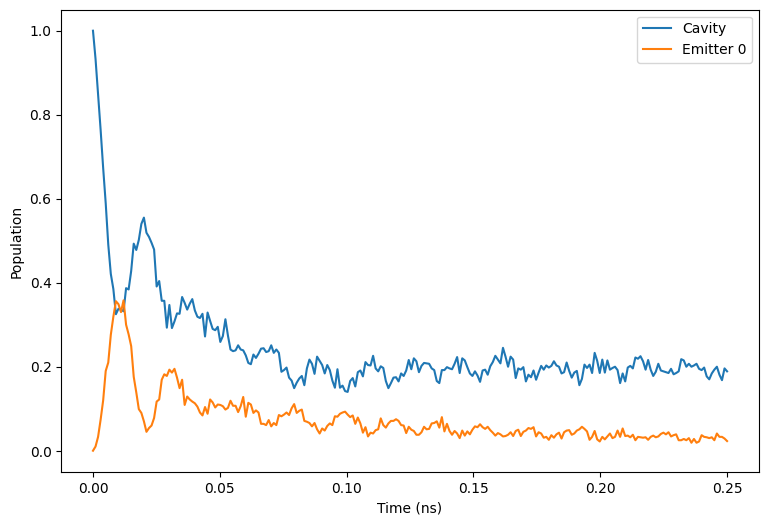

[1.0, 0.933, 0.85, 0.764, 0.673, 0.589, 0.491, 0.421, 0.385, 0.325, 0.338, 0.336, 0.332, 0.387, 0.384, 0.428, 0.493, 0.478, 0.502, 0.54, 0.555, 0.519, 0.509, 0.495, 0.479, 0.391, 0.404, 0.357, 0.357, 0.293, 0.347, 0.292, 0.308, 0.327, 0.326, 0.366, 0.352, 0.336, 0.35, 0.361, 0.334, 0.319, 0.316, 0.326, 0.272, 0.329, 0.309, 0.29, 0.287, 0.295, 0.259, 0.273, 0.313, 0.274, 0.241, 0.237, 0.239, 0.251, 0.241, 0.239, 0.227, 0.209, 0.206, 0.229, 0.221, 0.231, 0.243, 0.244, 0.235, 0.237, 0.251, 0.233, 0.241, 0.233, 0.188, 0.192, 0.198, 0.174, 0.167, 0.149, 0.162, 0.172, 0.178, 0.156, 0.196, 0.217, 0.207, 0.183, 0.224, 0.214, 0.204, 0.184, 0.204, 0.192, 0.167, 0.15, 0.194, 0.15, 0.155, 0.142, 0.14, 0.166, 0.173, 0.153, 0.187, 0.191, 0.177, 0.211, 0.204, 0.203, 0.226, 0.196, 0.189, 0.201, 0.197, 0.166, 0.149, 0.161, 0.174, 0.175, 0.165, 0.184, 0.178, 0.191, 0.216, 0.194, 0.22, 0.213, 0.187, 0.202, 0.209, 0.208, 0.207, 0.196, 0.192, 0.166, 0.161, 0.192, 0.192, 0.199, 0.196, 0.194, 0.207, 0.223, 0

In [ ]:
def runN(N, emitters, start_photons = 1):
  """
  Plots the measurements of the system over time.

  Generates a list of times to take measurements. Then, for each times, calls
  JmethodN and gets the populations of the cavity and emitters. Then, plots them
  below.

  Parameter N: the number of times to apply J and H each time the JMethod is run.
  Precondition: N is a positive integer.

  Parameter emitters: Number of emitters in the system
  Precondition: emitters is a positive integer

  Parameter start_photons: the number of photons to pump the cavity with.
  Precondition: start_photons is either 0,1,2, or 3.
  """
  tlist = np.linspace(0, .25, 250)

  poplist = []
  emitlist = [[] for i in range(emitters)]
  for i in range(len(tlist)):
    if i %10 == 0:
      print("Working on iteration " + str(i))
    g2, pop, em = JmethodN(emitters = emitters, start_photons = start_photons, t = tlist[i], N = N)
    poplist.append(pop)
    for j in range(len(em)):
      emitlist[j].append(em[j])

  plt.figure(figsize=(9,6))
  plt.plot(tlist, poplist, label = 'Cavity')
  for j in range(len(emitlist)):
    plt.plot(tlist, emitlist[j], label = str(j)+' Emitter')

  plt.legend(labels = ['Cavity'] + ['Emitter ' + str(i) for i in range(emitters)])
  # Adding labels and title
  plt.xlabel('Time (ns)')
  plt.ylabel('Population')

  plt.show()

  print(poplist)
  print(emitlist)
runN(100, 1, 1)

In [ ]:
def g2_experiment(t, shots):
  """
  Subroutine to calculate g2 values. Shots should be relatively high.

  Parameter t: the simulation time.
  Precondition: t is a positive float.

  Parameter shots: the number of shots to take.
  Precondition: shots is a positive int.
  """
  counts = JmethodN(emitters = 1, start_photons = 1, t = t, N = 2000, shots = shots, getcavcount=True)
  population = (3 * counts.get("11", 0) + 2 * counts.get("10", 0) + 1 * counts.get("01", 0))/shots
  try:
    g2 = (6* counts.get("11", 0) + 2 * counts.get("10", 0))/(shots * (population ** 2))
  except ZeroDivisionError:
    g2 = 0

  return counts, g2

g2_experiment(1.8, 500)




({'10': 1, '00': 441, '01': 58}, 0.2777777777777778)